In [17]:
import pyLIMA, os, sys
import numpy as np
import matplotlib.pyplot as plt
from pyLIMA import event, telescopes
from pyLIMA.simulations import simulator
from pyLIMA.models import FSPL_model,USBL_model,PSPL_model
from ipywidgets import interactive, HBox, VBox, Layout
from ipywidgets import (FloatSlider, FloatLogSlider, interactive_output, HBox, VBox, GridBox, Layout, Label)
from IPython.display import display
current_path = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_path, os.pardir))
print("Parent Directory:", parent_directory)
sys.path.append(parent_directory)
import pyLIMA_plots

Parent Directory: /home/anibal-pc/microlensing/simulation_Rubin/roman_rubin


In [18]:
def get_param_order(m):
    for attr in ("model_dictionnary", "model_dictionary", "parameters_names", "parameter_names"):
        if hasattr(m, attr):
            val = getattr(m, attr)
            if isinstance(val, dict): 
                return list(val.keys())
            if isinstance(val, (list, tuple)): 
                return list(val)
    # fallback mínimo
    return ["t0", "u0", "tE", "piEN", "piEE", "fs_G", "fb_G"]

# --- Función de ploteo usando TODOS los valores de los widgets ---
def plot_from_widgets(**kw):
    # p arranca de la simulación base (garantiza completar faltantes)
    p = dict(sim_dict)

    # Actualizar con lo que venga de widgets
    p.update(kw)

    # Por compatibilidad: algunos modelos esperan nombres específicos; si algún
    # nombre del orden esperado no está en p, se toma de sim_dict (ya quedó arriba)
    params_list = [p[name] if name in p else sim_dict.get(name, None) for name in param_order]

    # Construir parámetros pyLIMA y magnificación
    py_params = model.compute_pyLIMA_parameters(params_list)
    A = model.model_magnification(model.event.telescopes[0], py_params)

    plt.figure(dpi=130)
    plt.plot(time_sim, A, lw=1.2, label=" 2S1L Magnification")
    plt.xlabel("Time (JD)")
    plt.ylabel(r"Magnification")
    plt.legend()
    plt.tight_layout()
    plt.show()

Create event, define telescope and choose a model

In [19]:
# ---- Event & telescope ----
simulated_event = event.Event()
simulated_event.name = 'Simulated'
simulated_event.ra = 170
simulated_event.dec = -70

t0guess = 50
# u0guess = 0.01
time_sim = np.linspace(0, 100, 500)
lightcurve_sim = np.c_[time_sim, np.full_like(time_sim, 19.0), np.full_like(time_sim, 0.01)]

tel = telescopes.Telescope(
    name='Simulation',
    camera_filter='G',
    lightcurve=lightcurve_sim.astype(float),
    lightcurve_names=['time','mag','err_mag'],
    lightcurve_units=['JD','mag','mag'],
    location='Earth'
)
simulated_event.telescopes.append(tel)

# ---- Model base (USBL con doble fuente circular) ----
model = PSPL_model.PSPLmodel(simulated_event, parallax=['None', 0], double_source=['Circular', t0guess])
model.define_model_parameters()

In [20]:
np.random.seed(0)
params0 = simulator.simulate_microlensing_model_parameters(model)
param_order = get_param_order(model)
# Convertir vector simulado en dict
sim_dict = {name: val for name, val in zip(param_order, params0)}
# ------------------ Config de sliders ------------------
pi = np.pi
DEFAULTS = {
    't0': (t0guess - 100, t0guess + 100, 0.5),
    'u0': (-1.5, 1.5, 0.001),
    'tE': (1.0, 500.0, 0.5),
    'xi_para': (-1.0, 1.0, 1e-3),
    'xi_perp': (-1.0, 1.0, 1e-3),
    'xi_angular_velocity': (0.0, 10.0, 1e-3),
    'xi_phase': (0.0, 2*pi, 1e-3),
    'xi_inclination': (0.0, pi, 1e-3),
    'xi_mass_ratio': (0.0, 1.0, 1e-3),
    'q_flux_G': (0.0, 5.0, 1e-3),  # razón de flujos (S2/S1), ajustá si querés
}

# Para flujos absolutos, uso log-sliders (rango muy amplio)
LOG_SLIDERS = {
    'fsource_Simulation': (1e-2, 1e9),   # flux arbitrario (ajustá a tu escala)
    'fblend_Simulation': (1e-2, 1e9),
}

# Valores iniciales desde tu OrderedDict de referencia
user_init = {
    't0': 50,
    'u0': 0.010000000000000009,
    'tE': 40.0,
    'xi_para': 0.19588650039103989,
    'xi_perp': 0.23183138025051464,
    'xi_angular_velocity': 2.4092341172487513,
    'xi_phase': 4.974555126607196,
    'xi_inclination': 0.09077606762179125,
    'xi_mass_ratio': 0.5680445610939323,
    'q_flux_G': 0.14207211639577388,
    'fsource_Simulation': 4_087_735.6365653505,
    'fblend_Simulation': 2_166.3963887910973,
}

# Construir widgets dinámicamente
widgets = {}
for name, init_val in user_init.items():
    if name in LOG_SLIDERS:
        low, high = LOG_SLIDERS[name]
        # centrar el rango si init_val está fuera
        if not (low <= init_val <= high):
            low = min(low, max(init_val/100, 1e-9))
            high = max(high, init_val*100)
        w = FloatLogSlider(
            value=max(init_val, 1e-12),
            base=10, min=np.log10(low), max=np.log10(high), step=0.01,
            description=name, continuous_update=False, readout_format=".3g", layout=Layout(width='340px')
        )
    elif name in DEFAULTS:
        lo, hi, st = DEFAULTS[name]
        # expandir suave si el init cae fuera
        if init_val < lo: lo = init_val - abs(init_val)*0.2 - 1e-9
        if init_val > hi: hi = init_val + abs(init_val)*0.2 + 1e-9
        w = FloatSlider(
            value=init_val, min=lo, max=hi, step=st,
            description=name, continuous_update=False, readout_format=".6g", layout=Layout(width='340px')
        )
    else:
        # parámetro no configurado: slider genérico alrededor del valor
        span = max(1.0, abs(init_val)*0.5)
        w = FloatSlider(
            value=init_val, min=init_val - span, max=init_val + span, step=span/1000,
            description=name, continuous_update=False, readout_format=".6g", layout=Layout(width='340px')
        )
    widgets[name] = w

# Layout en grilla para que no se haga infinito hacia la derecha
controls = GridBox(
    list(widgets.values()),
    layout=Layout(grid_template_columns='repeat(2, 360px)', grid_gap='6px 10px')
)

# Conectar widgets -> salida
out = interactive_output(plot_from_widgets, {k: w for k, w in widgets.items()})
display(VBox([controls, out]))

In [21]:
import numpy as np
from astropy import units as u
from astropy import constants as C
def thetaE(Ds, Dl, Ml):
    """
    Ds (float): distance to the source in kpc
    Dl (float): distance to the lens in kpc
    Ml (float): mass of the lens in solar masses
    """
    dl = Dl*u.kpc
    ds = Ds*u.kpc
    M = Ml*u.M_sun

    k = 4*C.G/C.c**2
    pi_rel = 1/dl-1/ds
    arg = k*pi_rel*M
    thetaE = np.sqrt(arg)
    return thetaE.decompose()*u.rad
    
def generate_xiE(a_s, Ds, Dl, Ml, theta):
    """
    a_s (float): semi-major axis of the binary source system in AU
    Ds (float): distance to the source in kpc
    Dl (float): distance to the lens in kpc
    Ml (float): mass of the lens in solar masses
    theta (float): angle in radians
    """
    ds = Ds*u.kpc
    bot = thetaE(Ds, Dl, Ml)
    top = ((a_s*u.AU)/ds).decompose()*u.rad
    xiE = top/bot
    print(xiE)
    return xiE*np.cos(theta), xiE*np.sin(theta)  

def xi_mass_ratio(m1, m2): 
    """
    m1 (float): mass of primary source that is being magnified
    m2 (float): mass of companion
    """
    return ((m2*u.M_sun)/(m1*u.M_sun)).decompose()


def angular_velocity(P):
    """
    P (float): period in days
    return angular velocity in radians/day
    """
    return 2*np.pi/P

def tE(Ds, Dl, Ml, mu_rel):
    """
    mu_rel (float): relative proper motion in mas/year
    return tE in day
    """
    murel = mu_rel*u.mas/u.year
    return ((thetaE(Ds, Dl, Ml).to("mas"))/murel).to("day")

a_s = 2
Ds = 8
Dl = 4
Ml = 0.1
mu_rel = 5
theta = np.pi/2
P = 5
M1_source = 2
M2_source = 1
t0 = 50
u0 = 0.05
q_flux = 0.1
xiEE, xiEN = generate_xiE(a_s, Ds, Dl, Ml, theta)
print(np.sqrt(xiEE**2+ xiEN**2))
xi_q = xi_mass_ratio(2, 1)
omega = angular_velocity(P)
tE = tE(Ds, Dl, Ml, mu_rel).value
print(tE)
xi_inclination = 0
xi_phase = 0
ftotal=1000

0.7835559843595794
0.7835559843595794
23.307205055585673


In [22]:
import pandas as pd

data = [
    # Event 1
    {
        "Event": 1,
        "t_0": 50,
        "u_0": 0.05,
        "t_E": 12,
        "f_s": 1,
        "binary_flux_ratio": 0.1,
        "P": 0.4,
        "R": 0.01,
        "inclination": 0,
        "phi_0": 0
    },
    # Event 2
    {
        "Event": 2,
        "t_0": 50,
        "u_0": 0.5,
        "t_E": 35,
        "f_s": 1,
        "binary_flux_ratio": 0.1,
        "P": 60,
        "R": 0.2,
        "inclination": 0,
        "phi_0": 0
    },
    # Event 3
    {
        "Event": 3,
        "t_0": 50,
        "u_0": 0.2,
        "t_E": 30,
        "f_s": 1,
        "binary_flux_ratio": 0.1,
        "P": 25,
        "R": 0.1,
        "inclination": 0,
        "phi_0": 0
    },
    # Event 4
    {
        "Event": 4,
        "t_0": 50,
        "u_0": 0.1,
        "t_E": 25,
        "f_s": 1,
        "binary_flux_ratio": 0.1,
        "P": 7,
        "R": 0.05,
        "inclination": 0,
        "phi_0": 0
    },
    # Event 5
    {
        "Event": 5,
        "t_0": 50,
        "u_0": 0.3,
        "t_E": 15,
        "f_s": 1,
        "binary_flux_ratio": 0.1,
        "P": 1.5,
        "R": 0.02,
        "inclination": 0,
        "phi_0": 0
    }
]

df = pd.DataFrame(data)
display(df)


,Event,t_0,u_0,t_E,f_s,binary_flux_ratio,P,R,inclination,phi_0
0,1,50,0.05,12,1,0.1,0.4,0.01,0,0
1,2,50,0.50,35,1,0.1,60.0,0.20,0,0
2,3,50,0.20,30,1,0.1,25.0,0.10,0,0
3,4,50,0.10,25,1,0.1,7.0,0.05,0,0
4,5,50,0.30,15,1,0.1,1.5,0.02,0,0


pyLIMA parameters OrderedDict({'t0': np.float64(50.0), 'u0': np.float64(0.3), 'tE': np.float64(15.0), 'xi_para': np.float64(0.014142135623730952), 'xi_perp': np.float64(0.014142135623730949), 'xi_angular_velocity': np.float64(4.1887902047863905), 'xi_phase': np.float64(0.0), 'xi_inclination': np.float64(0.0), 'xi_mass_ratio': 0.1, 'q_flux_G': 1, 'fsource_Simulation': 1, 'ftotal_Simulation': None})


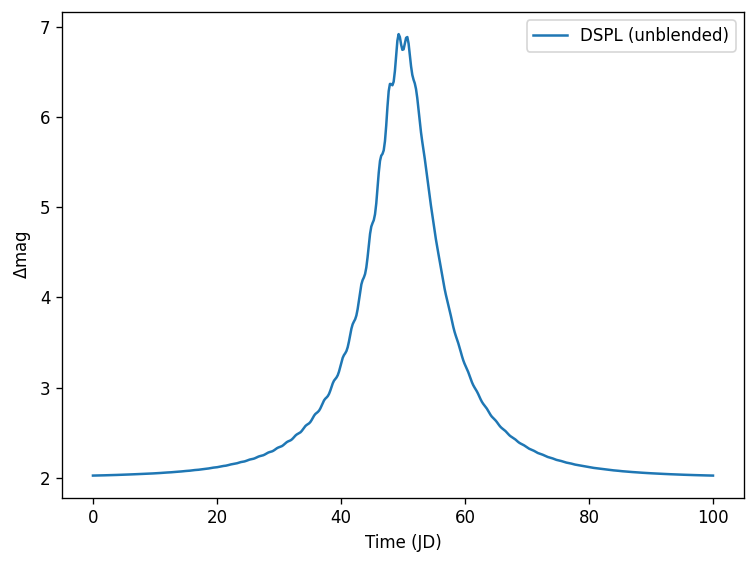

In [23]:
# params_list = [0]*11
# params_list[0] = t0 
# params_list[1] = u0 
# params_list[2] = tE 
# params_list[3] = xiEE
# params_list[4] = xiEN
# params_list[5] = omega
# params_list[6] = xi_phase
# params_list[7] = xi_inclination
# params_list[8] = xi_q
# params_list[9] = q_flux
# params_list[10] = ftotal 
params_list = [0]*11
i=4
df_row = df.iloc[i]
params_list[0] = df_row['t_0'] 
params_list[1] = df_row['u_0'] 
params_list[2] = df_row['t_E'] 
params_list[3] = df_row['R']*np.cos(np.pi/4)
params_list[4] = df_row['R']*np.sin(np.pi/4)
params_list[5] = 2*np.pi/df_row['P']
params_list[6] = df_row['phi_0']
params_list[7] = df_row['inclination']
params_list[8] = 0.1
params_list[9] = 1
params_list[10] = 1 
plt.close("all")
%matplotlib inline
py_params = model.compute_pyLIMA_parameters(params_list)

print("pyLIMA parameters", py_params)
A = model.model_magnification(model.event.telescopes[0], py_params)

plt.figure(dpi=120)
plt.plot(time_sim, A, label="DSPL (unblended)")

# np.savez(f"/home/anibal/comparision_binary_sources/Event_{i}.npz", time_sim=time_sim, A=A)
plt.xlabel("Time (JD)")
plt.ylabel(r"$\Delta$mag")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
model.event.telescopes[0].lightcurve['time']

<Quantity [  0.        ,   0.2004008 ,   0.4008016 ,   0.6012024 ,
             0.80160321,   1.00200401,   1.20240481,   1.40280561,
             1.60320641,   1.80360721,   2.00400802,   2.20440882,
             2.40480962,   2.60521042,   2.80561122,   3.00601202,
             3.20641283,   3.40681363,   3.60721443,   3.80761523,
             4.00801603,   4.20841683,   4.40881764,   4.60921844,
             4.80961924,   5.01002004,   5.21042084,   5.41082164,
             5.61122244,   5.81162325,   6.01202405,   6.21242485,
             6.41282565,   6.61322645,   6.81362725,   7.01402806,
             7.21442886,   7.41482966,   7.61523046,   7.81563126,
             8.01603206,   8.21643287,   8.41683367,   8.61723447,
             8.81763527,   9.01803607,   9.21843687,   9.41883768,
             9.61923848,   9.81963928,  10.02004008,  10.22044088,
            10.42084168,  10.62124248,  10.82164329,  11.02204409,
            11.22244489,  11.42284569,  11.62324649,  11.82364

In [25]:
# py_params

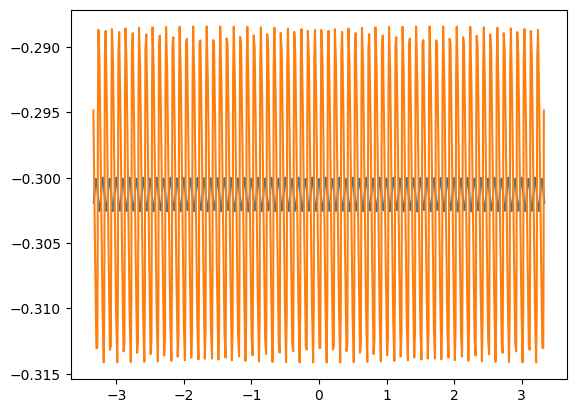

In [26]:
(source1_trajectory_x, source1_trajectory_y,
                source2_trajectory_x, source2_trajectory_y,
                dseparation, dalpha) = model.sources_trajectory(model.event.telescopes[0], py_params, data_type='photometry')
plt.plot(source1_trajectory_x,source1_trajectory_y)
plt.plot(source2_trajectory_x,source2_trajectory_y)

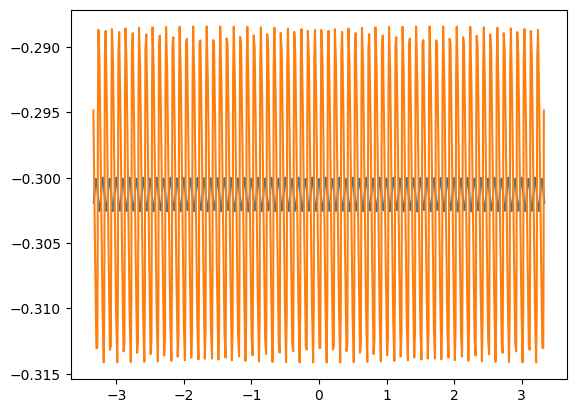

In [27]:
plt.plot(source1_trajectory_x,source1_trajectory_y)
plt.plot(source2_trajectory_x,source2_trajectory_y)

(<Figure size 700x700 with 1 Axes>, None)

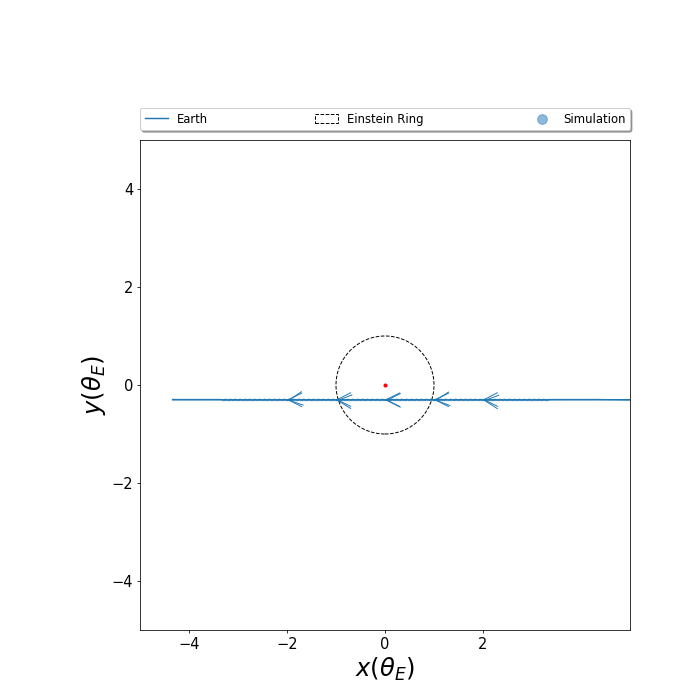

In [28]:
%matplotlib ipympl
pyLIMA_plots.plot_geometry(model, params_list)